In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import src.tetraphymac.logical_channels as lc
import src.tetraphymac.physical_channels as pc
import src.tetraphymac.modulation as tetraMod

In [3]:
from numpy import pi as pi
from numpy import complex64, int16, float64, uint8, cos, sin, log10
from numpy.typing import NDArray

# Modulation and Coding Code
The steps to prepare data for testing are basic as follows:
1. Generate random 0,1 data
2. Scramble data
3. Modulate the data via pi/4 dqpsk modulation
4. Oversample the data and convert into quantized half-scale 16 bit values

In [4]:
pkt_traffic_ch = lc.TCH_4_8(N=4)
pkt_traffic_ch.encodeType5Bits(pkt_traffic_ch.generateRndInput(4))

ul_tp_rf_channel = pc.Physical_Channel(1, False, 905.1, 918.1, pc.PhyType.TRAFFIC_CHANNEL)

ul_tp_burst = pc.Normal_Uplink_Burst(ul_tp_rf_channel, 1, 1, 1)
burst_modulation_bits = ul_tp_burst.constructBurstBitSequence(pkt_traffic_ch)
print(burst_modulation_bits)
symbols = tetraMod.dqpskModulator(burst_modulation_bits)

[0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0
 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1
 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1
 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0
 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1
 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0
 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1
 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1
 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0
 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0
 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0
 1 0 1 0 1 0 0 1 0 1 0 1 

In [5]:
def oversampleDataQuantized(inputData: NDArray[complex64], overSampleRate:int):
    outputData = np.zeros(shape=(2, inputData.size*overSampleRate), dtype=int64)
    # because the modulation mapped only on the unit circle, the max value is 1, and min is zero
    # for this module, we quantize scaling by 0.5 then multiplying by our maximum value to provide headroom in later calculations
    tempIvalues = (inputData.real* ((2 ** 18) - 1)) / 2
    tempQvalues = (inputData.imag* ((2 ** 18) - 1)) / 2
    outputData[0][0::overSampleRate] = tempIvalues.astype(int64)
    outputData[1][0::overSampleRate] = tempQvalues.astype(int64)
    return outputData
    
def oversampleDataFloat(inputData: NDArray[complex64], overSampleRate:int):
    outputData = np.zeros(shape=(2, inputData.size*overSampleRate), dtype=np.float32)
    tempIvalues = inputData.real
    tempQvalues = inputData.imag
    outputData[0][0::overSampleRate] = tempIvalues.astype(np.float32)
    outputData[1][0::overSampleRate] = tempQvalues.astype(np.float32)
    return outputData



In [6]:
sps = 8
x = oversampleDataFloat(symbols, sps)
print(x)
print(x.shape[1])

[[-0.70710677  0.          0.         ...  0.          0.
   0.        ]
 [ 0.70710677  0.          0.         ...  0.          0.
   0.        ]]
2040


# Baseband Filtering and Processing
The steps to process Tx data are as follows
1. Take the zero-padded upsampled data and peform RRC filtering (rolloff of 0.35)
2. Perform a cleanup using an FIR to meet 25kHz offset ACPR
3. Remove flushed bits (assuming this is normal uplink burst) and apply power ramping in guard periods
4. Perform Halfband upsampling and filtering (x2)
5. Perform Halfband upsampling and filtering (x2)
6. Perform Halfband upsampling and filter (x2)

This results in an x64 upsampling `64 * 18_000sps = 1_152_000sps`. This relaxes the analog reconstruction filtering requirements

## RRC Filter Generation

In [50]:
def rrc_calculator(OSR:int, symbolSpan:int,beta:float=0.35):
    N = (symbolSpan * OSR) + 1
    n0 = (N-1)//2
    h = np.zeros(shape=N, dtype=np.float32)
    for n in range(N):
        tn = ((n-n0)/OSR)
        if np.isclose(tn, 0):
            h[n] = 1 - beta + ((4*beta)/pi)
        else:
            if np.isclose(tn, (1/(4*beta))) or np.isclose(tn,(-1/(4*beta))):
                h[n] = (beta/(2**(0.5)))*((1+(2/pi))*sin(pi/(4*beta)) + (1-(2/pi))*cos(pi/(4*beta)))
            else:
                h[n] = ((sin(pi*tn*(1-beta)))+(4*beta*tn*cos(pi*tn*(1+beta))))/(pi*tn*(1-((4*beta*tn)**2)))
    h /= h.sum(axis=0)
    return h


In [51]:
h_rrc = rrc_calculator(sps, 14, 0.35)
print(h_rrc)

[ 3.2547283e-05  3.2207786e-04  5.2808010e-04  5.8573583e-04
  4.6815889e-04  1.9697665e-04 -1.5991251e-04 -5.0379767e-04
 -7.3058502e-04 -7.5993093e-04 -5.6027190e-04 -1.6242533e-04
  3.4303279e-04  8.2534668e-04  1.1462410e-03  1.1978352e-03
  9.3581964e-04  3.9825984e-04 -2.9658416e-04 -9.7493920e-04
 -1.4502126e-03 -1.5738290e-03 -1.2810810e-03 -6.1880576e-04
  2.5482883e-04  1.1016943e-03  1.6614646e-03  1.7233356e-03
  1.1939828e-03  1.4279077e-04 -1.1910767e-03 -2.4372363e-03
 -3.1748905e-03 -3.0411342e-03 -1.8429373e-03  3.5534150e-04
  3.1950125e-03  6.0541783e-03  8.1505440e-03  8.7031256e-03
  7.1246121e-03  3.2053748e-03 -2.7531665e-03 -9.8923352e-03
 -1.6859306e-02 -2.1981161e-02 -2.3528602e-02 -2.0027600e-02
 -1.0563596e-02  4.9805501e-03  2.5803484e-02  5.0213095e-02
  7.5808890e-02  9.9796265e-02  1.1938435e-01  1.3220197e-01
  1.3666072e-01  1.3220197e-01  1.1938435e-01  9.9796265e-02
  7.5808890e-02  5.0213095e-02  2.5803484e-02  4.9805501e-03
 -1.0563596e-02 -2.00276

In [52]:
print(len(h_rrc))
polyphase_interpolater_length = np.ceil(len(h_rrc)/sps)

113


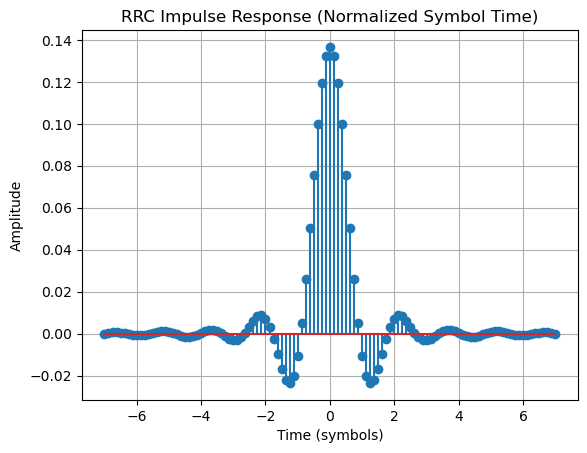

In [53]:
N = len(h_rrc)
n0 = (N - 1) // 2

t_sym = (np.arange(N) - n0) / sps

plt.figure()
plt.stem(t_sym, h_rrc)
plt.xlabel("Time (symbols)")
plt.ylabel("Amplitude")
plt.title("RRC Impulse Response (Normalized Symbol Time)")
plt.grid(True)
plt.show()

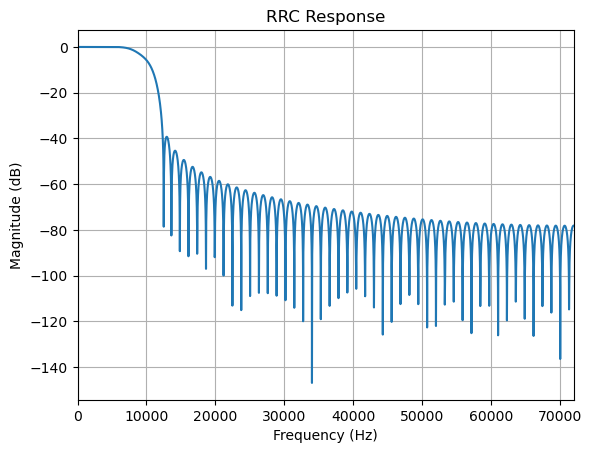

[-1.0354388e-06 -1.7084756e-05 -6.8856949e-05 ... -7.8225075e+01
 -7.8204811e+01 -7.8191788e+01]


In [54]:
from numpy.fft import fft, fftshift

Fs = (sps * 18000)  # sampling rate (Hz)
N_fft = 8192

H = sp.fft.rfft(h_rrc, N_fft)
f = sp.fft.rfftfreq(N_fft, d=1/Fs)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("RRC Response")
plt.grid(True)
plt.xlim(0, 72_000)
plt.show()
print(20*np.log10(np.abs(H) + 1e-12))

In [12]:
Q = 17
scale = 2**Q
h_fixed = np.round(h_rrc * scale).astype(np.int32)
h_fixed = np.clip(h_fixed, -2**17, 2**17 -1)
print("Min:", h_fixed.min(), "Max:", h_fixed.max())

Min: -3084 Max: 17912


In [13]:
yI = sp.signal.lfilter(h_rrc, 1.0, x[0])
yQ = sp.signal.lfilter(h_rrc, 1.0, x[1])
group_delay = (len(h_rrc)-1)//2
print(group_delay)
y = yI + 1j*yQ
print(f"Length of fir output: {len(y)}, length of og data: {len(x[0])}")
y_aligned = y
print(len(y_aligned))

56
Length of fir output: 2040, length of og data: 2040
2040


- Because of 8sps zero insertions, we can compute the RRC FIR as polyphase with number of phases = 8, resulting in 12 taps per phase. 
- This requires 12 MACs per phase, however by time-multiplexing and using 6 DSP blocks with each doing 2 MACs per symbol (aka 2 tap calculations) we only require 6 DSP blocks per channels for RRC calculations
- Image at `1*f_symbol_rate=18,000` not really a concern because input data is dqpsk which is WSS therefore approx awgn like
- Channel leakage at +/- 25KHz, 50KHz, 75Khz are the man issues
- Also, wideband noise 
  

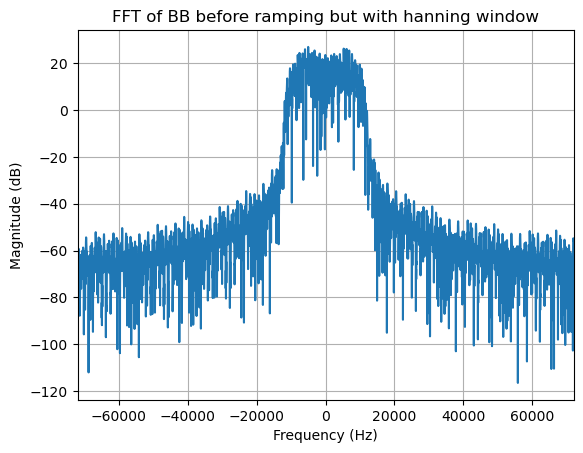

In [14]:
N = 131072
w = np.hanning(len(y_aligned))
yw = y_aligned * w

Y = np.fft.fftshift(np.fft.fft(yw, n=N))
f = np.fft.fftshift(np.fft.fftfreq(N, d=1/Fs))

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Y) + 1e-15))
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("FFT of BB before ramping but with hanning window")
plt.xlim(-72e3, 72e3)
plt.show()

## Power Ramping
1. At the start and end guards, we apply power ramping

In [15]:
def raised_cosine(N:int):
    n = np.arange(N, dtype=np.float32)
    return 0.5 * (1.0 - np.cos(pi * n / (N-1)))

def power_ramping(I:NDArray[np.float32], Q:NDArray[np.float32], sps:int, startGuard:int=17, endGuard:int=7):
    N = len(I)
    Nu = int(startGuard * sps)
    Nd = int(endGuard *sps)

    envelope = np.ones(N, dtype=np.float32)

    upRamp = raised_cosine(Nu)
    downRamp = raised_cosine(Nd)
    envelope[:Nu] = upRamp
    envelope[-Nd:] = downRamp[::-1]

    return I * envelope, Q * envelope
    

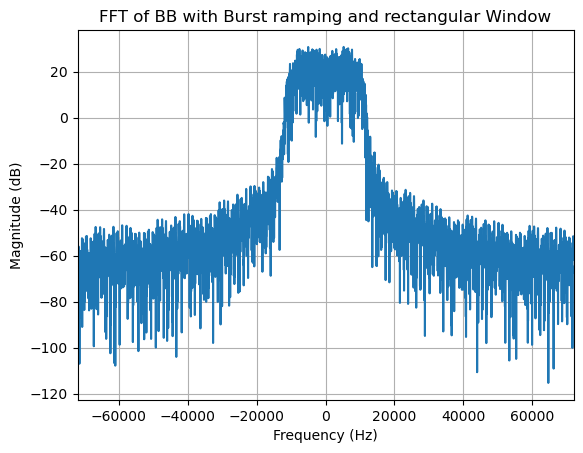

In [16]:
yI_aligned = yI
yQ_aligned = yQ

yI_ramp, yQ_ramp = power_ramping(yI_aligned, yQ_aligned, 8, 17, 7)

y_ramp = yI_ramp + 1j*yQ_ramp

N = 131072
yw_ramp = y_ramp

Yramp = np.fft.fftshift(np.fft.fft(yw_ramp, n=N))
f = np.fft.fftshift(np.fft.fftfreq(N, d=1/Fs))

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Yramp) + 1e-15))
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("FFT of BB with Burst ramping and rectangular Window")
plt.xlim(-(sps*18_000/2), (sps*18_000/2))
plt.show()

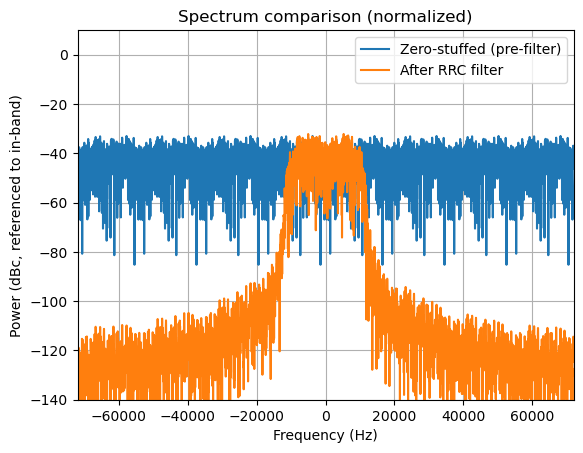

In [17]:
def spectrum_db(x, Fs, N=131072):
    x = np.asarray(x)
    X = np.fft.fftshift(np.fft.fft(x, n=N))
    f = np.fft.fftshift(np.fft.fftfreq(N, d=1/Fs))
    P = np.abs(X)**2
    return f, P

def bandpower(f, P, flo, fhi):
    idx = (f >= flo) & (f <= fhi)
    return P[idx].sum()

Fs = sps*18_000
x_total = x[0] + 1j*x[1]
f, Px = spectrum_db(x_total, Fs)
_, Py = spectrum_db(y_ramp, Fs)

f2 = 0.5*(1.35 * 18_000)
Pref_x = bandpower(f, Px, 0, f2)
Pref_y = bandpower(f, Py, 0, f2)

Px_dBc = 10*np.log10((Px + 1e-30) / (Pref_x + 1e-30))
Py_dBc = 10*np.log10((Py + 1e-30) / (Pref_y + 1e-30))

plt.figure()
plt.plot(f, Px_dBc, label="Zero-stuffed (pre-filter)")
plt.plot(f, Py_dBc, label="After RRC filter")
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dBc, referenced to in-band)")
plt.title("Spectrum comparison (normalized)")
plt.xlim(-72e3, 72e3)
plt.ylim(-140, 10)
plt.legend()
plt.show()

In [18]:
y_no_ramp = yI_aligned + 1j*yQ_aligned
y_ramp    = yI_ramp    + 1j*yQ_ramp

print("|y| end before ramp:", np.abs(y_no_ramp[-1]))
print("|y| end after  ramp:", np.abs(y_ramp[-1]))


|y| end before ramp: 0.14460837611270522
|y| end after  ramp: 0.0


In [19]:
Rs = 18_000
beta = 0.35
B = (1 + beta) * Rs     # 24.3 kHz
half = B / 2            # 12.15 kHz

def channel_power(f, P, fc, B):
    half = B/2
    return bandpower(f, P, fc-half, fc+half)

Pch0_y  = channel_power(f, Py, 0.0,  B)
Pch25_y = channel_power(f, Py, 25e3, B)
Pch50_y = channel_power(f, Py, 50e3, B)

acpr25 = 10*np.log10((Pch25_y + 1e-30) / (Pch0_y + 1e-30))
acpr50 = 10*np.log10((Pch50_y + 1e-30) / (Pch0_y + 1e-30))

print("25 kHz ACPR (rect ch power):", acpr25, "dBc")
print("50 kHz ACPR (rect ch power):", acpr50, "dBc")


25 kHz ACPR (rect ch power): -52.246964586021505 dBc
50 kHz ACPR (rect ch power): -76.12106930550355 dBc


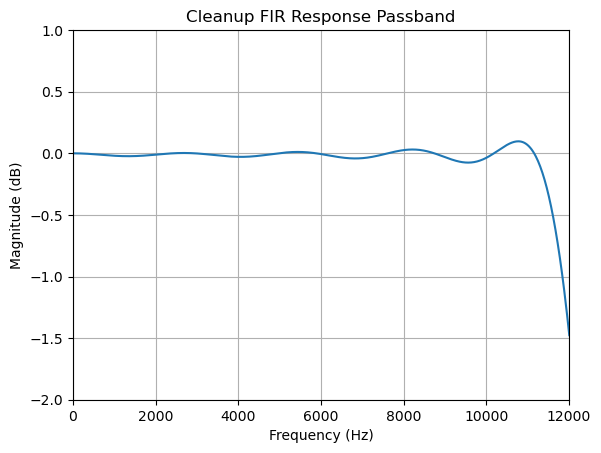

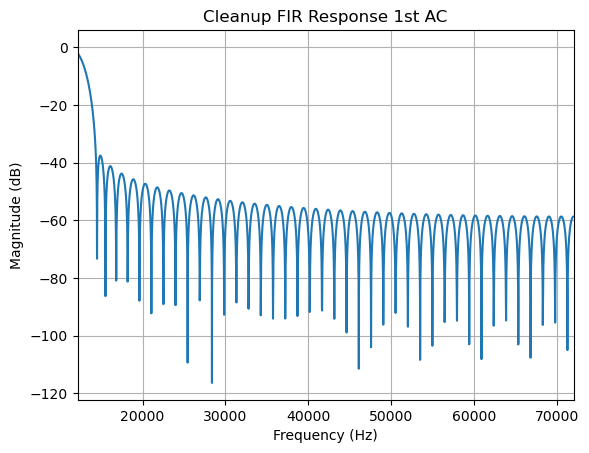

[ 1.32726717e-03  1.42472293e-03  1.03345124e-03  1.83235570e-04
 -9.20058038e-04 -1.93491309e-03 -2.48268151e-03 -2.27803671e-03
 -1.24905465e-03  3.98514746e-04  2.20527574e-03  3.57634633e-03
  3.96675370e-03  3.07922156e-03  1.00692563e-03 -1.73687266e-03
 -4.32946656e-03 -5.87212433e-03 -5.68409511e-03 -3.56562497e-03
  6.36383776e-05  4.21503261e-03  7.57932938e-03  8.91744148e-03
  7.48284627e-03  3.34018909e-03 -2.53893875e-03 -8.46453992e-03
 -1.24780360e-02 -1.29530314e-02 -9.17425213e-03 -1.70697354e-03
  7.58833102e-03  1.59488370e-02  2.04432719e-02  1.88686111e-02
  1.05615371e-02 -3.12613251e-03 -1.88678151e-02 -3.19679872e-02
 -3.74272273e-02 -3.12217610e-02 -1.14726410e-02  2.08156077e-02
  6.16738418e-02  1.04811238e-01  1.42862585e-01  1.68958031e-01
  1.78240361e-01  1.68958031e-01  1.42862585e-01  1.04811238e-01
  6.16738418e-02  2.08156077e-02 -1.14726410e-02 -3.12217610e-02
 -3.74272273e-02 -3.19679872e-02 -1.88678151e-02 -3.12613251e-03
  1.05615371e-02  1.88686

In [20]:
N = 97
cutoff = 12_850
h_clean = sp.signal.firwin(N, cutoff=cutoff, window=("kaiser", 3.0), fs=Fs)


Fs = (sps * 18000)
N_fft = 8192

H = sp.fft.rfft(h_clean, N_fft)
f = sp.fft.rfftfreq(N_fft, d=1/Fs)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Cleanup FIR Response Passband")
plt.grid(True)
plt.xlim(0, 12_000)
plt.ylim(-2, 1)
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Cleanup FIR Response 1st AC")
plt.grid(True)
plt.xlim(12_150, 72_000)
plt.show()
print(h_clean)

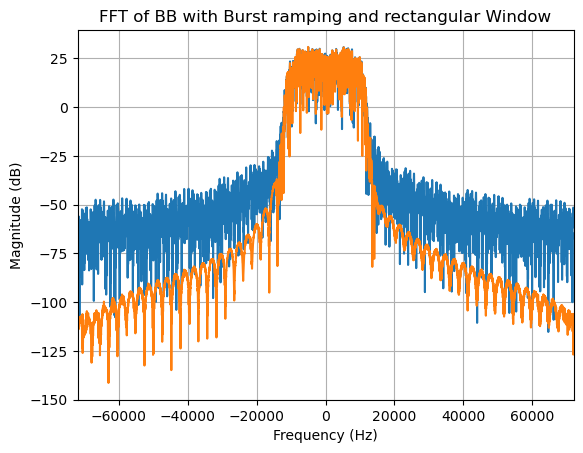

In [21]:
yI_clean = sp.signal.lfilter(h_clean, 1.0, yI)
yQ_clean = sp.signal.lfilter(h_clean, 1.0, yQ)
GD_clean = (len(h_clean)-1)//2
GD_total = GD_clean + group_delay
yI_clean_aligned = yI_clean
yQ_clean_aligned = yQ_clean
yI_clean_ramp, yQ_clean_ramp = power_ramping(yI_clean_aligned, yQ_clean_aligned, 8, 17, 7)
y_clean_ramp = yI_clean_ramp + 1j*yQ_clean_ramp

N = 131072
yw_clean_ramp = y_clean_ramp

Yramp_clean = np.fft.fftshift(np.fft.fft(yw_clean_ramp, n=N))
f = np.fft.fftshift(np.fft.fftfreq(N, d=1/Fs))

plt.figure()
plt.plot(f, 20*np.log10(np.abs(Yramp) + 1e-15))
plt.plot(f, 20*np.log10(np.abs(Yramp_clean) + 1e-15))
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("FFT of BB with Burst ramping and rectangular Window")
plt.xlim(-(sps*18_000/2), (sps*18_000/2))
plt.show()

In [22]:
def ensembleTestACPR(iterationNumber:int=100, cleanup_filter_w=None):
    acpr25, acpr50 = [], []
    ul_tp_rf_channel = pc.Physical_Channel(1, False, 905.1, 918.1, pc.PhyType.TRAFFIC_CHANNEL)
    ul_tp_burst = pc.Normal_Uplink_Burst(ul_tp_rf_channel, 1, 1, 1)
    sps=8
    for _ in range(iterationNumber):
        pkt_traffic_ch = lc.TCH_4_8(N=1)
        pkt_traffic_ch.encodeType5Bits(pkt_traffic_ch.generateRndInput(1))
        burst_modulation_bits = ul_tp_burst.constructBurstBitSequence(pkt_traffic_ch)
        symbols = tetraMod.dqpskModulator(burst_modulation_bits)
        x = oversampleDataFloat(symbols, sps)
        yI = sp.signal.lfilter(h_rrc, 1.0, x[0])
        yQ = sp.signal.lfilter(h_rrc, 1.0, x[1])
        gd_rrc = (len(h_rrc)-1)//2
        gd_clean = 0
        if cleanup_filter_w is not None:
            yI = sp.signal.lfilter(cleanup_filter_w, 1.0, yI)
            yQ = sp.signal.lfilter(cleanup_filter_w, 1.0, yQ)
            gd_clean = (len(cleanup_filter_w) - 1) // 2
            
        gd_total = gd_rrc + gd_clean
        gd_total = 0
        yI_aligned = yI[gd_total : (gd_total + len(x[0]))]
        yQ_aligned = yQ[gd_total : (gd_total + len(x[0]))]
        
        yI_ramp, yQ_ramp = power_ramping(yI_aligned, yQ_aligned, 8, 17, 7)
        
            
        y_ramp = yI_ramp + 1j*yQ_ramp
        Fs = sps*18_000
        f, Py = spectrum_db(y_ramp, Fs)
        f2 = 0.5*(1.35 * 18_000)
        Pref_y = bandpower(f, Py, 0, f2)

        Pch0_y  = channel_power(f, Py, 0.0,  B)
        Pch25_y = channel_power(f, Py, 25e3, B)
        Pch50_y = channel_power(f, Py, 50e3, B)
        
        acpr25.append(10*np.log10((Pch25_y + 1e-30) / (Pch0_y + 1e-30)))
        acpr50.append(10*np.log10((Pch50_y + 1e-30) / (Pch0_y + 1e-30)))
    return (np.mean(acpr25), np.std(acpr25)), (np.mean(acpr50), np.std(acpr50))


In [23]:
N = 101
cutoff = 12_850
h_clean = sp.signal.firwin(N, cutoff=cutoff, window=("kaiser", 3.0), fs=Fs)

In [24]:
# pure RRC only
stats25, stats50 = ensembleTestACPR(100)
print("Only RRC Results:")
print(f"14span 25k mean/std: {stats25[0]}/{stats25[1]}")
print(f"14span 50k mean/std: {stats50[0]}/{stats50[1]}")
stats25, stats50 = ensembleTestACPR(100, h_clean)
print("RRC + Cleanup FIR Results:")
print(f"14span 25k mean/std: {stats25[0]}/{stats25[1]}")
print(f"14span 50k mean/std: {stats50[0]}/{stats50[1]}")

Only RRC Results:
14span 25k mean/std: -53.12621916693114/0.9113696194069315
14span 50k mean/std: -76.32703682210177/0.25456746509848577
RRC + Cleanup FIR Results:
14span 25k mean/std: -60.38778241476763/2.5140216050429878
14span 50k mean/std: -111.4524927749537/1.9748673324289372


In [25]:
cutoff_6dB = 0.25 * 2 * 8 * 18_000
total_samp = 8*2*18_000
taps = 47
h_halfband_1 = sp.signal.firwin(taps,cutoff_6dB, fs=(18_000*2*8)) 
for k in range(len(h_halfband_1)):
    if abs(h_halfband_1[k]) < 1e-4:
        h_halfband_1[k] = 0
print(h_halfband_1)

bands = [0, 0.22*total_samp, 0.28*total_samp, 0.5*total_samp]
alt_h_half_1 = sp.signal.remez(taps, bands, [1,0], fs=total_samp)
for k in range(len(alt_h_half_1)):
    if abs(alt_h_half_1[k]) < 1e-4:
        alt_h_half_1[k] = 0
print(alt_h_half_1)

[-0.00110834  0.          0.00147274  0.         -0.00246479  0.
  0.00423664  0.         -0.00697565  0.          0.01094217  0.
 -0.01655212  0.          0.02457296  0.         -0.03665706  0.
  0.05715463  0.         -0.10217133  0.          0.3172838   0.50053275
  0.3172838   0.         -0.10217133  0.          0.05715463  0.
 -0.03665706  0.          0.02457296  0.         -0.01655212  0.
  0.01094217  0.         -0.00697565  0.          0.00423664  0.
 -0.00246479  0.          0.00147274  0.         -0.00110834]
[-0.00212166  0.          0.00269851  0.         -0.00434411  0.
  0.00660043  0.         -0.00963985  0.          0.0137221   0.
 -0.01925954  0.          0.0270377   0.         -0.03872287  0.
  0.05868987  0.         -0.1030579   0.          0.31728397  0.50000037
  0.31728397  0.         -0.1030579   0.          0.05868987  0.
 -0.03872287  0.          0.0270377   0.         -0.01925954  0.
  0.0137221   0.         -0.00963985  0.          0.00660043  0.
 -0.00434411

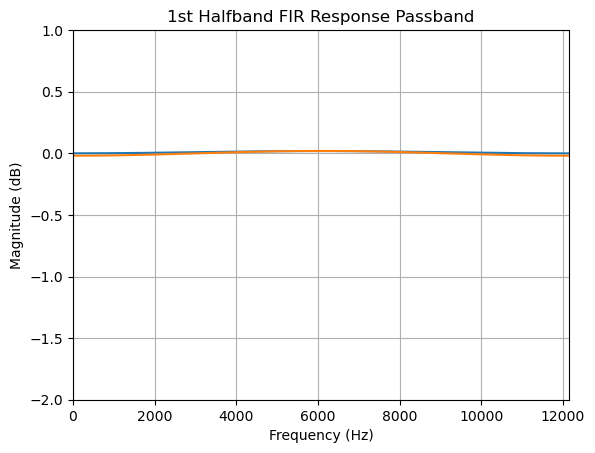

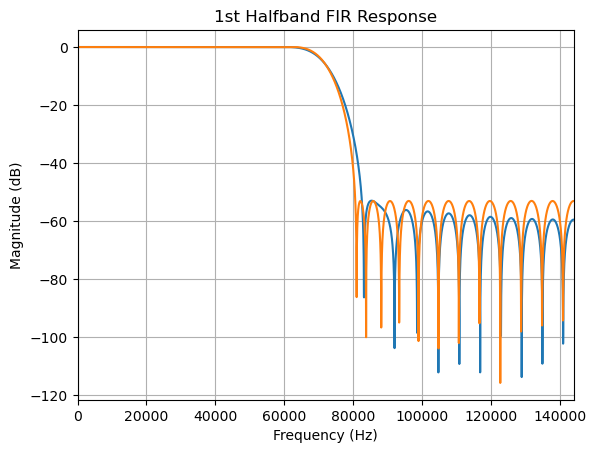

In [26]:
Fs = (sps * 18000 * 2)
N_fft = 8192

H = sp.fft.rfft(h_halfband_1, N_fft)
H2 = sp.fft.rfft(alt_h_half_1, N_fft)
f = sp.fft.rfftfreq(N_fft, d=1/Fs)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.plot(f, 20*np.log10(np.abs(H2) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("1st Halfband FIR Response Passband")
plt.grid(True)
plt.xlim(0, 12_150)
plt.ylim(-2, 1)
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.plot(f, 20*np.log10(np.abs(H2) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("1st Halfband FIR Response")
plt.grid(True)
plt.xlim(0, Fs/2)
plt.show()

1. For implementing this halfband filter we have 33 taps, most are zero, operating at only 144_000 sps, polyphase can have 5 multiplications per sample, with 2 phases

In [27]:
cutoff_6dB = 0.25 * 4 * 8 * 18_000
total_samp2 = 8*4*18_000
taps2 = 23
h_halfband_2 = sp.signal.firwin(taps2,cutoff_6dB, fs=(18_000*4*8)) 
for k in range(len(h_halfband_2)):
    if abs(h_halfband_2[k]) < 1e-4:
        h_halfband_2[k] = 0
print(h_halfband_2)
bands2 = [0, 0.22*total_samp2, 0.28*total_samp2, 0.5*total_samp2]
alt_h_half_2 = sp.signal.remez(taps2, bands2, [1,0], fs=total_samp2)
for k in range(len(alt_h_half_2)):
    if abs(alt_h_half_2[k]) < 1e-4:
        alt_h_half_2[k] = 0
print(alt_h_half_2)

[-0.0023201   0.          0.00542406  0.         -0.01590096  0.
  0.03863029  0.         -0.08945522  0.          0.31306928  0.50110528
  0.31306928  0.         -0.08945522  0.          0.03863029  0.
 -0.01590096  0.          0.00542406  0.         -0.0023201 ]
[-0.02349188  0.          0.02252751  0.         -0.03479829  0.
  0.05577488  0.         -0.10116103  0.          0.31670199  0.50004896
  0.31670199  0.         -0.10116103  0.          0.05577488  0.
 -0.03479829  0.          0.02252751  0.         -0.02349188]


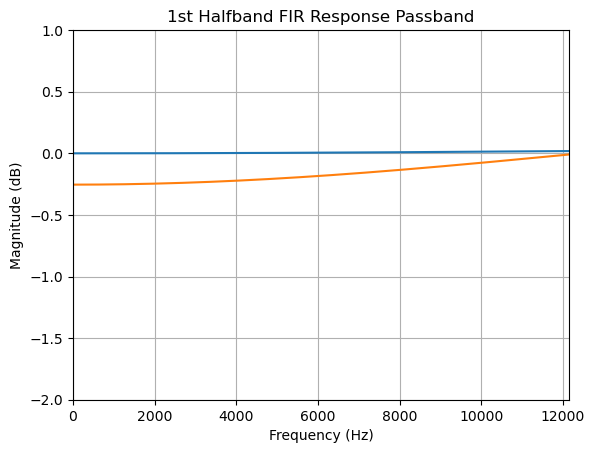

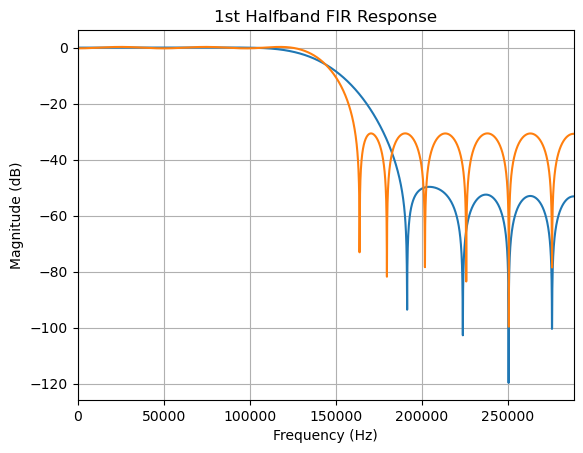

In [28]:
Fs = (sps * 18000 * 4)
N_fft = 8192
H = sp.fft.rfft(h_halfband_2, N_fft)
H2 = sp.fft.rfft(alt_h_half_2, N_fft)
f = sp.fft.rfftfreq(N_fft, d=1/Fs)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.plot(f, 20*np.log10(np.abs(H2) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("1st Halfband FIR Response Passband")
plt.grid(True)
plt.xlim(0, 12_150)
plt.ylim(-2, 1)
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.plot(f, 20*np.log10(np.abs(H2) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("1st Halfband FIR Response")
plt.grid(True)
plt.xlim(0, Fs/2)
plt.show()

In [29]:
cutoff_6dB = 0.25 * 8 * 8 * 18_000
taps3 = 11
total_samp3 = 8*8*18_000
h_halfband_3 = sp.signal.firwin(13,cutoff_6dB, fs=(18_000*8*8)) 
for k in range(len(h_halfband_3)):
    if abs(h_halfband_3[k]) < 1e-4:
        h_halfband_3[k] = 0
print(h_halfband_3)
bands3 = [0, 0.22*total_samp3, 0.28*total_samp3, 0.5*total_samp3]
alt_h_half_3 = sp.signal.remez(taps3, bands3, [1,0], fs=total_samp*4)
for k in range(len(alt_h_half_3)):
    if abs(alt_h_half_3[k]) < 1e-4:
        alt_h_half_3[k] = 0
print(alt_h_half_3)

[ 0.          0.00900889  0.         -0.05724843  0.          0.29844614
  0.4995868   0.29844614  0.         -0.05724843  0.          0.00900889
  0.        ]
[ 0.09460285  0.         -0.10097541  0.          0.31641282  0.49991718
  0.31641282  0.         -0.10097541  0.          0.09460285]


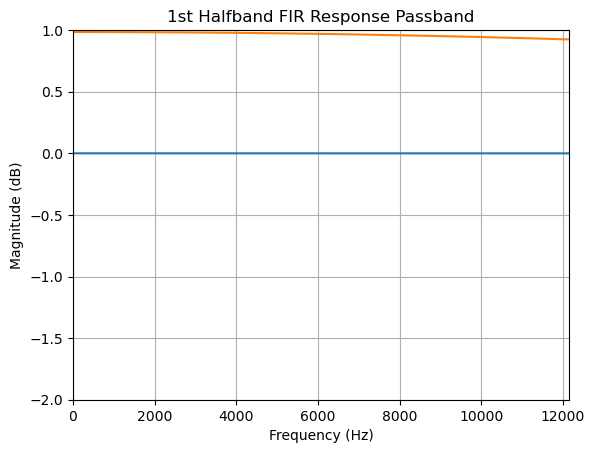

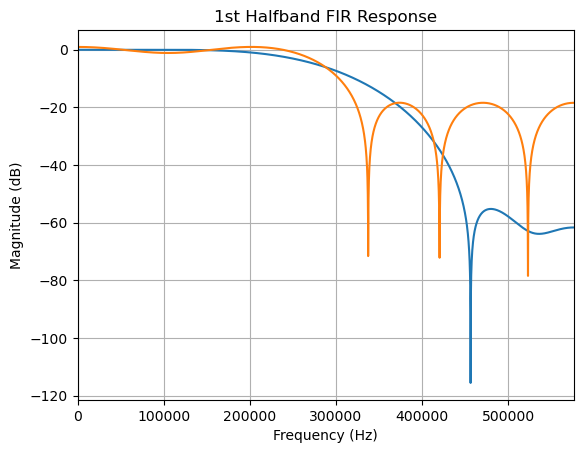

In [30]:
Fs = (sps * 18000 * 8)
N_fft = 8192

H = sp.fft.rfft(h_halfband_3, N_fft)
H2 = sp.fft.rfft(alt_h_half_3, N_fft)
f = sp.fft.rfftfreq(N_fft, d=1/Fs)

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.plot(f, 20*np.log10(np.abs(H2) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("1st Halfband FIR Response Passband")
plt.grid(True)
plt.xlim(0, 12_150)
plt.ylim(-2, 1)
plt.show()

plt.figure()
plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
plt.plot(f, 20*np.log10(np.abs(H2) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("1st Halfband FIR Response")
plt.grid(True)
plt.xlim(0, Fs/2)
plt.show()

In [31]:
def ensembleTestACPRExtended(iterationNumber:int=100, cleanup_filter_w=None, halfband_fir=None):
    acpr25, acpr50, acpr75, acpr100_250, acpr250_500 = [], [], [], [], []
    ul_tp_rf_channel = pc.Physical_Channel(1, False, 905.1, 918.1, pc.PhyType.TRAFFIC_CHANNEL)
    ul_tp_burst = pc.Normal_Uplink_Burst(ul_tp_rf_channel, 1, 1, 1)
    sps=8
    for _ in range(iterationNumber):
        pkt_traffic_ch = lc.TCH_4_8(N=1)
        pkt_traffic_ch.encodeType5Bits(pkt_traffic_ch.generateRndInput(1))
        burst_modulation_bits = ul_tp_burst.constructBurstBitSequence(pkt_traffic_ch)
        symbols = tetraMod.dqpskModulator(burst_modulation_bits)
        x = oversampleDataFloat(symbols, sps)
        yI = sp.signal.lfilter(h_rrc, 1.0, x[0])
        yQ = sp.signal.lfilter(h_rrc, 1.0, x[1])
        if cleanup_filter_w is not None:
            yI = sp.signal.lfilter(cleanup_filter_w, 1.0, yI)
            yQ = sp.signal.lfilter(cleanup_filter_w, 1.0, yQ)
        
        if halfband_fir is not None:
            i_old = yI
            q_old = yQ
            for i in range(len(halfband_fir)):
                i_new = np.zeros(shape=len(i_old)*2, dtype=np.float32)
                q_new = np.zeros(shape=len(q_old)*2, dtype=np.float32)
                i_new[0::2] = i_old
                q_new[0::2] = q_old

                i_new = sp.signal.lfilter(halfband_fir[i], 1.0, i_new)
                q_new = sp.signal.lfilter(halfband_fir[i], 1.0, q_new)

                i_old = i_new.copy()
                q_old = q_new.copy()
            yI = i_old.copy()
            yQ = q_old.copy()

        
        b, a = sp.signal.bessel(8, 100E3, btype='lowpass', analog=False, fs=8*8*18_000)
        yI = sp.signal.lfilter(b, a, yI)
        yQ = sp.signal.lfilter(b, a, yQ)
        yI_ramp, yQ_ramp = power_ramping(yI, yQ, 8*8, 17, 7)
            
        y_ramp = yI_ramp + 1j*yQ_ramp
        w = np.hanning(len(y_ramp))
        Fs = sps*8*18_000
        f, Py = spectrum_db(y_ramp*w, Fs)
        f2 = 0.5*(1.35 * 18_000)
        Pref_y = bandpower(f, Py, 0, f2)
        B = (1.35*18_000)/2

        
        Pch0_y  = channel_power(f, Py, 0.0,  B)
        Pch25_y = channel_power(f, Py, 25e3, B)
        Pch50_y = channel_power(f, Py, 50e3, B)
        Pch75_y = channel_power(f, Py, 75e3, B)
        Pch100_250_y = channel_power(f, Py, 175e3, 150E3)
        Pch250_500_y = channel_power(f, Py, 375e3, 250E3)
        
        acpr25.append(10*np.log10((Pch25_y + 1e-30) / (Pch0_y + 1e-30)))
        acpr50.append(10*np.log10((Pch50_y + 1e-30) / (Pch0_y + 1e-30)))
        acpr75.append(10*np.log10((Pch75_y + 1e-30) / (Pch0_y + 1e-30)))
        acpr100_250.append(10*np.log10((Pch100_250_y + 1e-30) / (Pch0_y + 1e-30)))
        acpr250_500.append(10*np.log10((Pch250_500_y + 1e-30) / (Pch0_y + 1e-30)))

    N = 131072
    Yramp = np.fft.fftshift(np.fft.fft(y_ramp, n=N))
    f = np.fft.fftshift(np.fft.fftfreq(N, d=1/Fs))
    
    plt.figure()
    plt.plot(f, 20*np.log10(np.abs(Yramp) + 1e-15))
    plt.grid(True)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("FFT of BB Composite Filters")
    plt.xlim(-(sps*8*18_000/2), (sps*8*18_000/2))
    plt.show()
        
        
    return (acpr25, acpr50, acpr75, acpr100_250, acpr250_500)

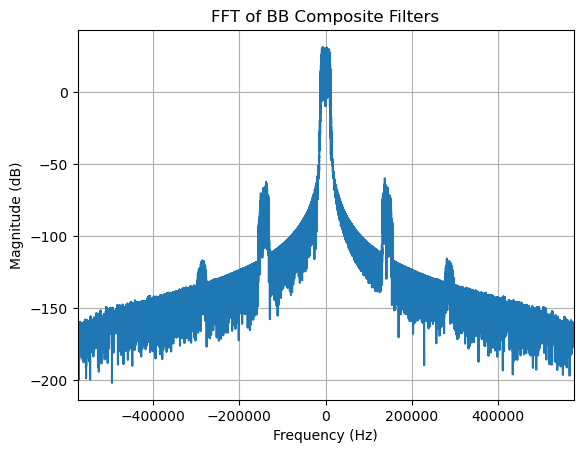

25khz: -119.30685071536578/0.9376252520829103
50khz: -150.44671135717624/1.1447917933782688
75khz: -162.4283178635948/1.1897563313649164
100-250khz: -95.6092066452623/0.5233686834953393
250-500khz: -147.6395864523283/0.202791785577493


In [32]:
acpr25, acpr50, acpr75, acpr100_250, acpr250_500 = ensembleTestACPRExtended(1000, cleanup_filter_w=h_clean, halfband_fir=[h_halfband_1, h_halfband_2, h_halfband_3])
print(f"25khz: {np.mean(acpr25)}/{np.std(acpr25)}")
print(f"50khz: {np.mean(acpr50)}/{np.std(acpr50)}")
print(f"75khz: {np.mean(acpr75)}/{np.std(acpr75)}")
print(f"100-250khz: {np.mean(acpr100_250)}/{np.std(acpr100_250)}")
print(f"250-500khz: {np.mean(acpr250_500)}/{np.std(acpr250_500)}")

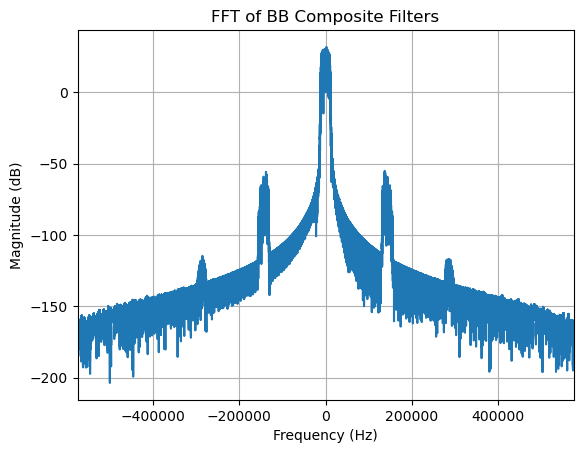

25khz: -119.33435653826248/0.9273472779854647
50khz: -150.51800553330676/1.1372094101904715
75khz: -162.40611436351068/1.1486892614041682
100-250khz: -89.22229696845395/0.5293853151435782
250-500khz: -147.65023141893099/0.20516302192388014


In [33]:
acpr25, acpr50, acpr75, acpr100_250, acpr250_500 = ensembleTestACPRExtended(1000, cleanup_filter_w=h_clean, halfband_fir=[alt_h_half_1, h_halfband_2, h_halfband_3])
print(f"25khz: {np.mean(acpr25)}/{np.std(acpr25)}")
print(f"50khz: {np.mean(acpr50)}/{np.std(acpr50)}")
print(f"75khz: {np.mean(acpr75)}/{np.std(acpr75)}")
print(f"100-250khz: {np.mean(acpr100_250)}/{np.std(acpr100_250)}")
print(f"250-500khz: {np.mean(acpr250_500)}/{np.std(acpr250_500)}")

In [55]:
print(h_rrc)
print(h_clean)

[ 3.2547283e-05  3.2207786e-04  5.2808010e-04  5.8573583e-04
  4.6815889e-04  1.9697665e-04 -1.5991251e-04 -5.0379767e-04
 -7.3058502e-04 -7.5993093e-04 -5.6027190e-04 -1.6242533e-04
  3.4303279e-04  8.2534668e-04  1.1462410e-03  1.1978352e-03
  9.3581964e-04  3.9825984e-04 -2.9658416e-04 -9.7493920e-04
 -1.4502126e-03 -1.5738290e-03 -1.2810810e-03 -6.1880576e-04
  2.5482883e-04  1.1016943e-03  1.6614646e-03  1.7233356e-03
  1.1939828e-03  1.4279077e-04 -1.1910767e-03 -2.4372363e-03
 -3.1748905e-03 -3.0411342e-03 -1.8429373e-03  3.5534150e-04
  3.1950125e-03  6.0541783e-03  8.1505440e-03  8.7031256e-03
  7.1246121e-03  3.2053748e-03 -2.7531665e-03 -9.8923352e-03
 -1.6859306e-02 -2.1981161e-02 -2.3528602e-02 -2.0027600e-02
 -1.0563596e-02  4.9805501e-03  2.5803484e-02  5.0213095e-02
  7.5808890e-02  9.9796265e-02  1.1938435e-01  1.3220197e-01
  1.3666072e-01  1.3220197e-01  1.1938435e-01  9.9796265e-02
  7.5808890e-02  5.0213095e-02  2.5803484e-02  4.9805501e-03
 -1.0563596e-02 -2.00276

In [111]:
def convertFixedPoint(inputData: NDArray):
    print(inputData.sum())
    newStr = ""
    for i in range(len(inputData)):
        newStr += (f"{inputData[i]:.7E}, ")
    print(f"[{newStr}]")
    print()
    newData = np.zeros(shape=len(inputData), dtype=np.int64)
    tempData = (inputData * (2**17)).copy()
    newData = (np.round(tempData)).copy().astype(np.int64)
    newStr = ""
    for i in range(len(inputData)):
        newStr += (f"{newData[i]}, ")
    print(f"[{newStr}]")
    return newData


In [112]:
h_rrc_quantized = convertFixedPoint(h_rrc)
print(h_rrc_quantized.sum())
print((2**17))

0.9999999
[3.2547283E-05, 3.2207786E-04, 5.2808010E-04, 5.8573583E-04, 4.6815889E-04, 1.9697665E-04, -1.5991251E-04, -5.0379767E-04, -7.3058502E-04, -7.5993093E-04, -5.6027190E-04, -1.6242533E-04, 3.4303279E-04, 8.2534668E-04, 1.1462410E-03, 1.1978352E-03, 9.3581964E-04, 3.9825984E-04, -2.9658416E-04, -9.7493920E-04, -1.4502126E-03, -1.5738290E-03, -1.2810810E-03, -6.1880576E-04, 2.5482883E-04, 1.1016943E-03, 1.6614646E-03, 1.7233356E-03, 1.1939828E-03, 1.4279077E-04, -1.1910767E-03, -2.4372363E-03, -3.1748905E-03, -3.0411342E-03, -1.8429373E-03, 3.5534150E-04, 3.1950125E-03, 6.0541783E-03, 8.1505440E-03, 8.7031256E-03, 7.1246121E-03, 3.2053748E-03, -2.7531665E-03, -9.8923352E-03, -1.6859306E-02, -2.1981161E-02, -2.3528602E-02, -2.0027600E-02, -1.0563596E-02, 4.9805501E-03, 2.5803484E-02, 5.0213095E-02, 7.5808890E-02, 9.9796265E-02, 1.1938435E-01, 1.3220197E-01, 1.3666072E-01, 1.3220197E-01, 1.1938435E-01, 9.9796265E-02, 7.5808890E-02, 5.0213095E-02, 2.5803484E-02, 4.9805501E-03, -1.05

In [113]:
h_clean_quantized = convertFixedPoint(h_clean)
print(h_clean_quantized.sum())
print((2**17))

0.9999999999999997
[3.0866607E-04, 1.0378698E-03, 1.5670853E-03, 1.6598026E-03, 1.1896548E-03, 2.0867007E-04, -1.0375803E-03, -2.1627121E-03, -2.7524120E-03, -2.5066389E-03, -1.3648995E-03, 4.3268623E-04, 2.3801184E-03, 3.8384833E-03, 4.2354544E-03, 3.2718693E-03, 1.0650634E-03, -1.8293252E-03, -4.5416570E-03, -6.1367146E-03, -5.9191459E-03, -3.7006680E-03, 6.5840668E-05, 4.3479592E-03, 7.7964842E-03, 9.1487500E-03, 7.6578711E-03, 3.4103186E-03, -2.5865371E-03, -8.6053726E-03, -1.2660975E-02, -1.3118963E-02, -9.2759097E-03, -1.7231343E-03, 7.6487811E-03, 1.6053667E-02, 2.0551295E-02, 1.8945906E-02, 1.0593299E-02, -3.1324285E-03, -1.8888838E-02, -3.1977766E-02, -3.7411781E-02, -3.1189190E-02, -1.1454434E-02, 2.0773036E-02, 6.1524669E-02, 1.0452736E-01, 1.4244613E-01, 1.6844460E-01, 1.7769138E-01, 1.6844460E-01, 1.4244613E-01, 1.0452736E-01, 6.1524669E-02, 2.0773036E-02, -1.1454434E-02, -3.1189190E-02, -3.7411781E-02, -3.1977766E-02, -1.8888838E-02, -3.1324285E-03, 1.0593299E-02, 1.89459

In [114]:
h_half1_quantized = convertFixedPoint(h_halfband_1)
print(h_half1_quantized.sum())
print((2**17))

1.0000000000000002
[-1.1083445E-03, 0.0000000E+00, 1.4727359E-03, 0.0000000E+00, -2.4647851E-03, 0.0000000E+00, 4.2366369E-03, 0.0000000E+00, -6.9756542E-03, 0.0000000E+00, 1.0942169E-02, 0.0000000E+00, -1.6552123E-02, 0.0000000E+00, 2.4572962E-02, 0.0000000E+00, -3.6657065E-02, 0.0000000E+00, 5.7154625E-02, 0.0000000E+00, -1.0217133E-01, 0.0000000E+00, 3.1728380E-01, 5.0053275E-01, 3.1728380E-01, 0.0000000E+00, -1.0217133E-01, 0.0000000E+00, 5.7154625E-02, 0.0000000E+00, -3.6657065E-02, 0.0000000E+00, 2.4572962E-02, 0.0000000E+00, -1.6552123E-02, 0.0000000E+00, 1.0942169E-02, 0.0000000E+00, -6.9756542E-03, 0.0000000E+00, 4.2366369E-03, 0.0000000E+00, -2.4647851E-03, 0.0000000E+00, 1.4727359E-03, 0.0000000E+00, -1.1083445E-03, ]

[-145, 0, 193, 0, -323, 0, 555, 0, -914, 0, 1434, 0, -2170, 0, 3221, 0, -4805, 0, 7491, 0, -13392, 0, 41587, 65606, 41587, 0, -13392, 0, 7491, 0, -4805, 0, 3221, 0, -2170, 0, 1434, 0, -914, 0, 555, 0, -323, 0, 193, 0, -145, ]
131070
131072


In [115]:
h_half2_quantized = convertFixedPoint(h_halfband_2)
print(h_half2_quantized.sum())
print((2**17))

0.9999999999999997
[-2.3200984E-03, 0.0000000E+00, 5.4240586E-03, 0.0000000E+00, -1.5900960E-02, 0.0000000E+00, 3.8630295E-02, 0.0000000E+00, -8.9455216E-02, 0.0000000E+00, 3.1306928E-01, 5.0110528E-01, 3.1306928E-01, 0.0000000E+00, -8.9455216E-02, 0.0000000E+00, 3.8630295E-02, 0.0000000E+00, -1.5900960E-02, 0.0000000E+00, 5.4240586E-03, 0.0000000E+00, -2.3200984E-03, ]

[-304, 0, 711, 0, -2084, 0, 5063, 0, -11725, 0, 41035, 65681, 41035, 0, -11725, 0, 5063, 0, -2084, 0, 711, 0, -304, ]
131073
131072


In [116]:
h_half3_quantized = convertFixedPoint(h_halfband_3)
print(h_half3_quantized.sum())
print((2**17))

0.9999999999999999
[0.0000000E+00, 9.0088874E-03, 0.0000000E+00, -5.7248430E-02, 0.0000000E+00, 2.9844614E-01, 4.9958680E-01, 2.9844614E-01, 0.0000000E+00, -5.7248430E-02, 0.0000000E+00, 9.0088874E-03, 0.0000000E+00, ]

[0, 1181, 0, -7504, 0, 39118, 65482, 39118, 0, -7504, 0, 1181, 0, ]
131072
131072


In [100]:
gainTotal = (h_half3_quantized.sum())*(h_half2_quantized.sum()) / (2**34) 
gainTotal *= ((h_half1_quantized.sum())*(h_clean_quantized.sum()) / (2**34))
gainTotal *= (h_rrc_quantized.sum() / (2**17))
print(gainTotal)

0.9999618531437626
